In [1]:
import sys
sys.path.append('/zhome/45/0/155089/Deeplearning_in_computer_vision/Video_classification/')

from datasets import FrameImageDataset, FrameVideoDataset
from torch.utils.data import DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt
from torchsummary import summary
import torch.nn as nn 
import torch.nn.functional as F
import torch 
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
# Definér root_dir og transformation
root_dir = '/dtu/blackhole/16/155094/ufc101'
#transform = T.Compose([T.Resize((64, 64)),T.ToTensor()])

transform = T.Compose([
    T.Resize((128, 128)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
#transform = T.Compose([T.Resize((64, 64)),T.ToTensor()])
batch_size = 16

# Initialize datasets
train_dataset = FrameVideoDataset(root_dir=root_dir, split='train', transform=transform, stack_frames = True)
val_dataset = FrameVideoDataset(root_dir=root_dir, split='val', transform=transform, stack_frames = True)
test_dataset = FrameVideoDataset(root_dir=root_dir, split='test', transform=transform, stack_frames = True)
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# frames in frameimage_loader is torch.Size([8, 3, 64, 64])
#frameimage_loader = DataLoader(frameimage_dataset,  batch_size=8, shuffle=False)
# frames in frameimage_loader is torch.Size([8, 3, 10, 64, 64])
#framevideostack_loader = DataLoader(framevideostack_dataset, batch_size=16, shuffle=True)
# 10 frames pr video, each with Video x: torch.Size([8, 3, 64, 64])
#framevideolist_loader = DataLoader(train_dataset,  batch_size=8, shuffle=False)

# train on the 


In [3]:
print(f"Antal billeder i træningssættet: {len(train_dataset)}")
print(f"Antal billeder i valssættet: {len(val_dataset)}")
print(f"Antal billeder i testsættet: {len(test_dataset)}")

Antal billeder i træningssættet: 500
Antal billeder i valssættet: 120
Antal billeder i testsættet: 120


In [ ]:
# Plot billeder og labels - lad være med at kør mig:)
for frames, labels in frameimage_loader:
    fig, axes = plt.subplots(1, len(frames), figsize=(15, 5))
    for i, ax in enumerate(axes):
        # Konverter tensor til numpy-array og transponér til (H, W, C)
        img = frames[i].permute(1, 2, 0).numpy()
        ax.imshow(img)
        ax.set_title(f"Label: {labels[i].item()}")
        ax.axis('off')
    plt.show()
    #break  # Kun vis ét batch


## The late fusion model ##

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv0 = nn.Conv2d(3, 16, kernel_size=7, stride=1, padding=3)
        self.conv1 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        
        
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, 128)  # Output 128-dimensional features

    def forward(self, x):
        x = F.relu(self.conv0(x))
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.global_avg_pool(x)  # [batch_size, 64, 1, 1]
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)  # [batch_size, 128]
        return x


class LateFusionModel(nn.Module):
    def __init__(self, base_model, feature_dim, num_classes):
        super(LateFusionModel, self).__init__()
        self.base_model = base_model
        self.fc1 = nn.Linear(feature_dim, 50)
        self.fc2 = nn.Linear(50, num_classes)

    def forward(self, video_tensor):
        """
        Args:
            video_tensor: Tensor of shape [batch_size, C, T, H, W]
        Returns:
            output: Tensor of shape [batch_size, num_classes]
        """
        batch_size, C, T, H, W = video_tensor.shape
        
        # Reshape to process all frames as a batch
        frames = video_tensor.permute(0, 2, 1, 3, 4)  # [batch_size, T, C, H, W]
        frames = frames.reshape(-1, C, H, W)  # [batch_size * T, C, H, W]
        
        # Extract features for all frames in parallel
        frame_features = self.base_model(frames)  # [batch_size * T, feature_dim]
        frame_features = frame_features.view(batch_size, T, -1)  # [batch_size, T, feature_dim]
        
        # Late Fusion: aggregate features across the time dimension
        video_features = frame_features.mean(dim=1)  # [batch_size, feature_dim]

        # Classification
        logits = self.fc1(video_features)  # [batch_size, num_classes]
        logitss = self.fc2(logits)
        return logitss


In [5]:
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=50):
    # Gem trænings- og valideringstab og nøjagtighed
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []  # Korrekt initialisering af listerne

    for epoch in range(num_epochs):
        # Træningstrin
        model.train()  # Sæt modellen til træningstilstand
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()  # Nulstil gradienterne

            outputs = model(inputs)  # Forward pass

            loss = criterion(outputs, labels)  # Beregn loss
            loss.backward()  # Backward pass
            optimizer.step()  # Opdater vægtene

            # Beregn nøjagtighed
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

            running_loss += loss.item()

        # Beregn gennemsnitligt træningstab og nøjagtighed
        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = (correct_predictions / total_predictions) * 100
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # Valideringstrin
        model.eval()  # Sæt modellen til evalueringsmodus
        val_loss = 0.0
        val_correct_predictions = 0
        val_total_predictions = 0

        with torch.no_grad():  # Ingen gradientberegning under validering
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)  # Forward pass

                loss = criterion(outputs, labels)  # Beregn loss
                val_loss += loss.item()

                # Beregn valideringsnøjagtighed
                _, predicted = torch.max(outputs, 1)
                val_correct_predictions += (predicted == labels).sum().item()
                val_total_predictions += labels.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = (val_correct_predictions / val_total_predictions) * 100
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        # Print status
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")
        print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
        
    return train_losses, train_accuracies, val_losses, val_accuracies


In [6]:
def test(model, test_loader, criterion, device):
    model.eval()  # Sæt modellen til evalueringsmodus
    test_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():  # Ingen gradientberegning under test
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)  # Forward pass

            loss = criterion(outputs, labels)  # Beregn loss
            test_loss += loss.item()

            # Beregn testnøjagtighed
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = (correct_predictions / total_predictions) * 100

    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    return avg_test_loss, test_accuracy


In [11]:
# try batchnorm?? - but first check issue.. 
# also, fiddle with image size. 

# Base model
base_model = SimpleCNN().to(device)  # SimpleCNN modellen

feature_dim = 128  # Output dimension af SimpleCNN's sidste fuldt forbundne lag
num_classes = 10  # For UFC101 dataset

# Initialiser model, criterion og optimizer
model = LateFusionModel(base_model, feature_dim, num_classes).to(device)
criterion = nn.CrossEntropyLoss()  # For eksempel
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# Træn og valider modellen
train_losses, train_accuracies, val_losses, val_accuracies = train_and_validate(
    model, train_loader, val_loader, criterion, optimizer, device, num_epochs=100
)

# Evaluér modellen på testdatasættet efter træning
test_loss, test_accuracy = test(model, test_loader, criterion, device)


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.50 GiB. GPU 0 has a total capacity of 15.77 GiB of which 1.86 GiB is free. Process 2167281 has 308.00 MiB memory in use. Process 2167222 has 3.40 GiB memory in use. Including non-PyTorch memory, this process has 10.21 GiB memory in use. Of the allocated memory 9.82 GiB is allocated by PyTorch, and 25.15 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# Plotting Loss over Epochs
epochs_range = range(1, 81)

plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

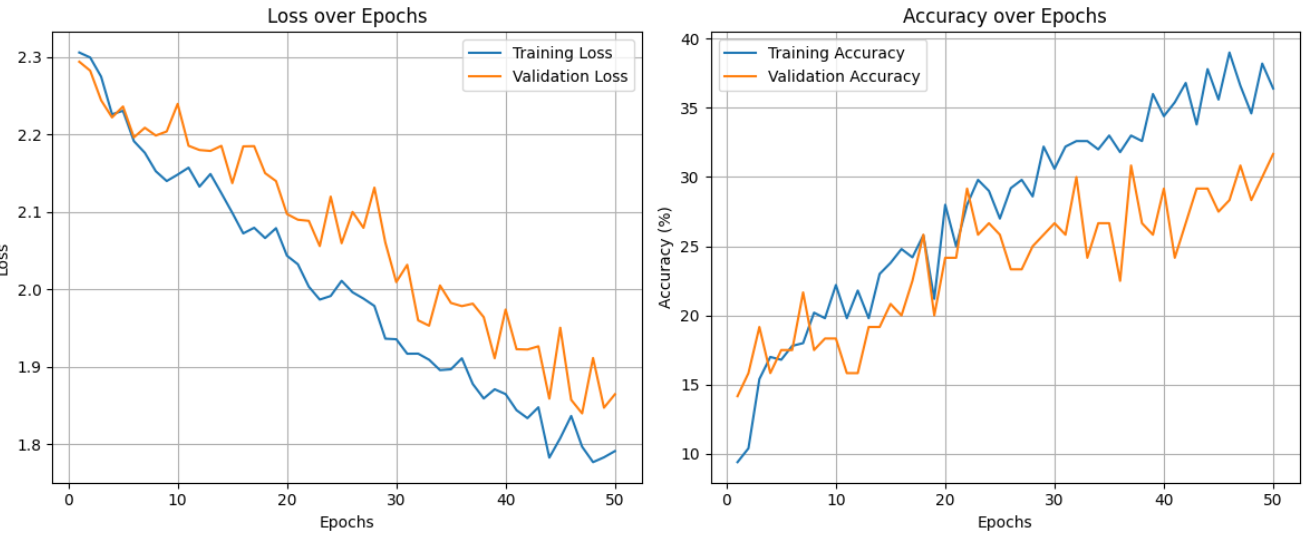

![image.png](attachment:image.png)

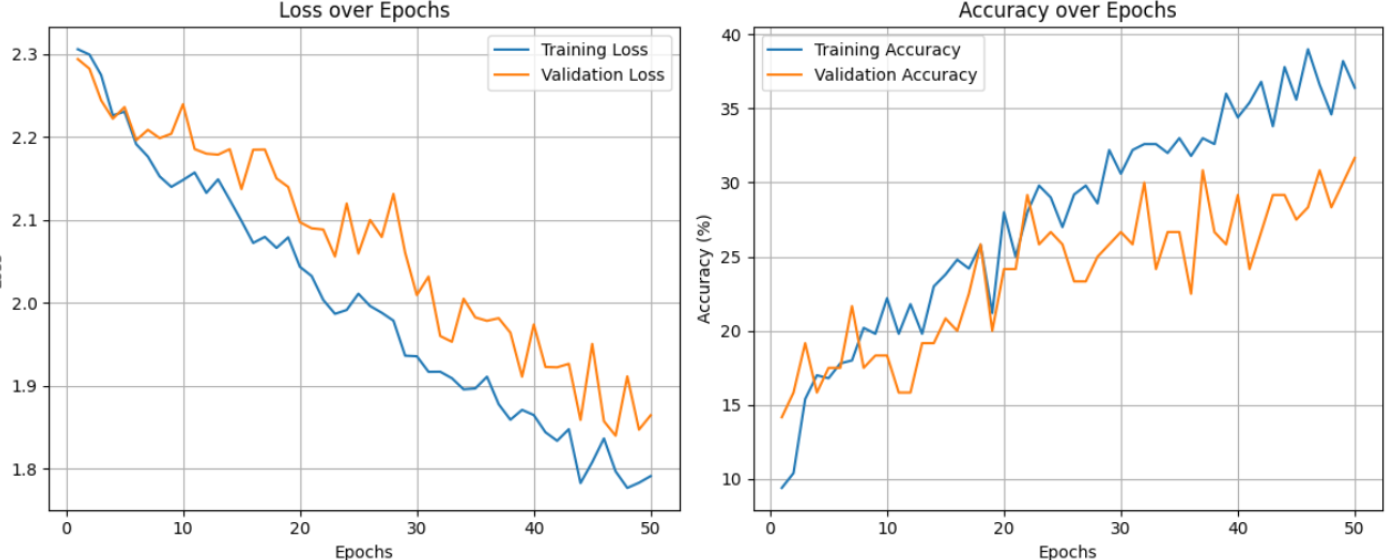